# Data Analysis and Preparation

In [1]:
# !pip install torch

In [2]:
# !pip install PyQtChart

In [3]:
# !pip install PyQtWebEngine

In [4]:
# from IPython.display import Image, display

# image_path = 'figs/swing-phases.png'
# display(Image(filename=image_path))


In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import json

# Helper function to load data from JSONL file
def load_data_from_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

# Modify the create_trajectory_plot function to handle the new data structure
def create_trajectory_plot(data):
    # Create a list to hold all predictions with frame numbers
    all_predictions = []
    for frame_num, frame_data in enumerate(data):
        for pred in frame_data.get('predictions', []):
            pred['frame'] = frame_num
            all_predictions.append(pred)
    
    # Create a DataFrame
    df = pd.DataFrame(all_predictions)
    
    # Get unique classes
    classes = df['class'].unique()
    
    # Create subplots: one for x-coordinate over time, one for y-coordinate
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        subplot_titles=("X-coordinate Trajectory", "Y-coordinate Trajectory"))
    
    # Color map for classes
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    color_map = dict(zip(classes, colors[:len(classes)]))
    
    for cls in classes:
        class_data = df[df['class'] == cls].sort_values('frame')
        
        # Add trace for x-coordinate
        fig.add_trace(
            go.Scatter(x=class_data['frame'], y=class_data['x'], mode='lines+markers',
                       name=f'{cls} (x)', line=dict(color=color_map[cls])),
            row=1, col=1
        )
        
        # Add trace for y-coordinate
        fig.add_trace(
            go.Scatter(x=class_data['frame'], y=class_data['y'], mode='lines+markers',
                       name=f'{cls} (y)', line=dict(color=color_map[cls], dash='dash')),
            row=2, col=1
        )
    
    # Update layout
    fig.update_layout(height=800, title_text="Object Trajectories in Golf Swing Video")
    fig.update_xaxes(title_text="Frame Number")
    fig.update_yaxes(title_text="X Position", row=1, col=1)
    fig.update_yaxes(title_text="Y Position", row=2, col=1)
    
    return fig


In [6]:
# Load data from JSONL file
data = load_data_from_jsonl('predictions/01_predictions.jsonl')

# Create the trajectory plot
fig = create_trajectory_plot(data)
fig.show()

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_evenly_distributed_frames(video_path, start_frame, end_frame, num_frames):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Calculate the frame positions to be plotted
    frame_positions = np.linspace(start_frame, end_frame, num_frames, dtype=int)
    
    # Calculate the number of rows and columns for the subplots
    cols = math.ceil(math.sqrt(num_frames))
    rows = math.ceil(num_frames / cols)
    
    # Create subplots with adjusted figure size for better visualization
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Read and plot specific frames
    for i, frame_position in enumerate(frame_positions):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_position)
        
        # Read the frame
        ret, frame = cap.read()
        
        if not ret:
            print(f"Error: Could not read frame at position {frame_position}.")
            continue
        
        # Convert the frame from BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Plot the frame
        axes[i].imshow(frame)
        axes[i].set_title(f'Frame {frame_position}')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(len(frame_positions), len(axes)):
        axes[j].axis('off')
    
    # Release the video capture object
    cap.release()
    
    # Adjust layout
    plt.tight_layout(pad=2.0)
    plt.show()



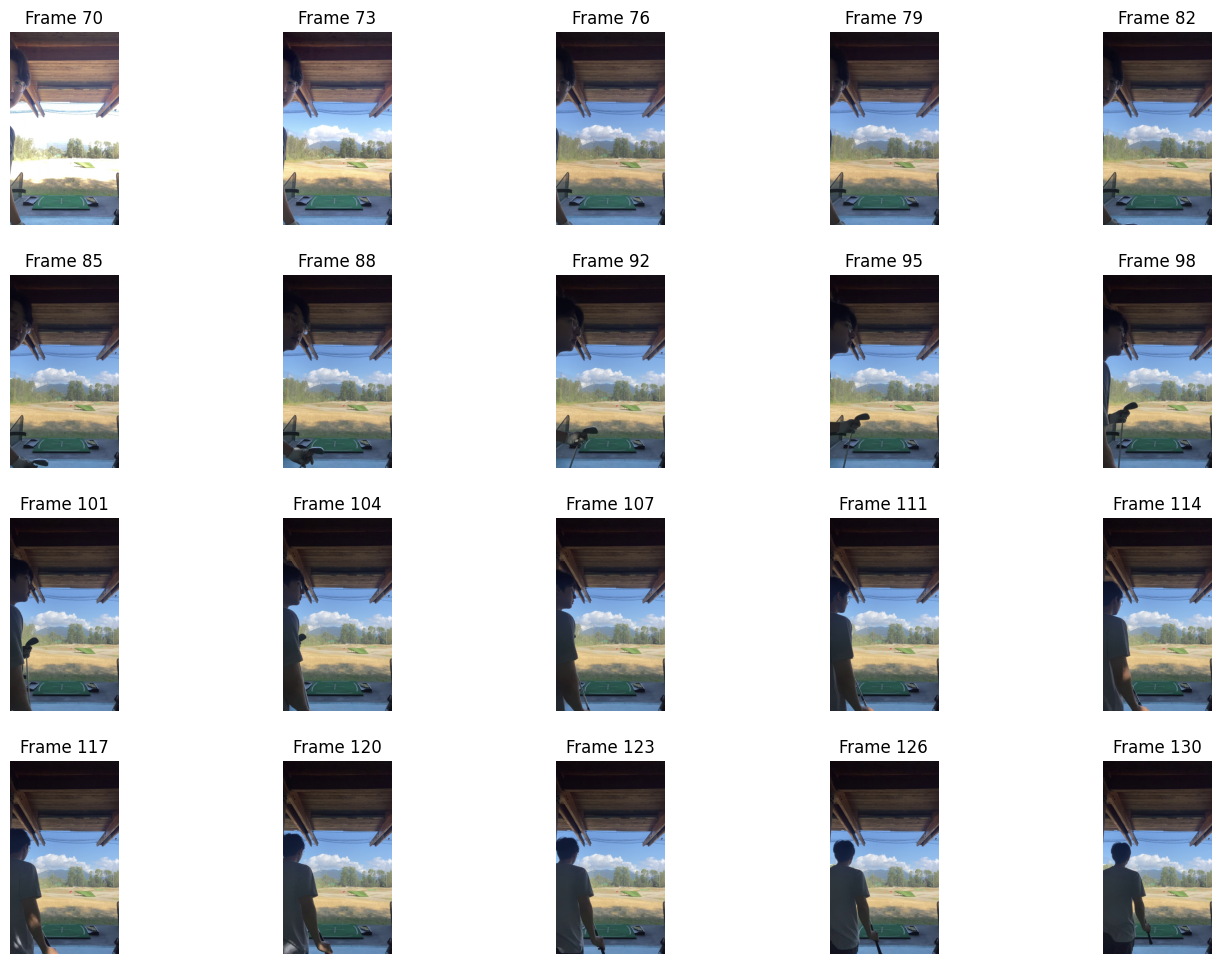

In [9]:
video_path = "input_videos/03.MOV"
start_frame = 70
end_frame = 130
num_frames = 20

plot_evenly_distributed_frames(video_path, start_frame, end_frame, num_frames)
fig.show()

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os

def load_data_from_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

def create_trajectory_plot(data, start_frame=None, end_frame=None):
    all_predictions = []
    for frame_num, frame_data in enumerate(data):
        if (start_frame is None or frame_num >= start_frame) and (end_frame is None or frame_num <= end_frame):
            for pred in frame_data.get('predictions', []):
                pred['frame'] = frame_num
                all_predictions.append(pred)
    
    df = pd.DataFrame(all_predictions)
    classes = df['class'].unique()
    
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        subplot_titles=("X-coordinate Trajectory", "Y-coordinate Trajectory"))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    color_map = dict(zip(classes, colors[:len(classes)]))
    
    for cls in classes:
        class_data = df[df['class'] == cls].sort_values('frame')
        
        fig.add_trace(
            go.Scatter(x=class_data['frame'], y=class_data['x'], mode='lines+markers',
                       name=f'{cls} (x)', line=dict(color=color_map[cls])),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(x=class_data['frame'], y=class_data['y'], mode='lines+markers',
                       name=f'{cls} (y)', line=dict(color=color_map[cls], dash='dash')),
            row=2, col=1
        )
    
    fig.update_layout(height=800, title_text="Object Trajectories in Golf Swing Video")
    fig.update_xaxes(title_text="Frame Number")
    fig.update_yaxes(title_text="X Position", row=1, col=1)
    fig.update_yaxes(title_text="Y Position", row=2, col=1)
    
    return fig

def plot_evenly_distributed_frames(video_path, start_frame=None, end_frame=None, num_frames=9):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    start_frame = 0 if start_frame is None else start_frame
    end_frame = total_frames - 1 if end_frame is None else end_frame

    frame_positions = np.linspace(start_frame, end_frame, num_frames, dtype=int)
    cols = math.ceil(math.sqrt(num_frames))
    rows = math.ceil(num_frames / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, frame_position in enumerate(frame_positions):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_position)
        ret, frame = cap.read()
        
        if not ret:
            print(f"Error: Could not read frame at position {frame_position}.")
            continue
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axes[i].imshow(frame)
        axes[i].set_title(f'Frame {frame_position}')
        axes[i].axis('off')
    
    for j in range(len(frame_positions), len(axes)):
        axes[j].axis('off')
    
    cap.release()
    plt.tight_layout(pad=2.0)
    return fig

def combined_plot(video_file, start_frame=None, end_frame=None, num_frames=9):
    # Construct file paths
    video_path = os.path.join('input_videos', video_file)
    jsonl_path = os.path.join('predictions', f"{os.path.splitext(video_file)[0]}_predictions.jsonl")

    # Load JSONL data
    data = load_data_from_jsonl(jsonl_path)

    # Create trajectory plot
    trajectory_fig = create_trajectory_plot(data, start_frame, end_frame)

    # Create distributed frames plot
    frames_fig = plot_evenly_distributed_frames(video_path, start_frame, end_frame, num_frames)

    # Display plots
    trajectory_fig.show()
    plt.figure(frames_fig.number)
    plt.show()


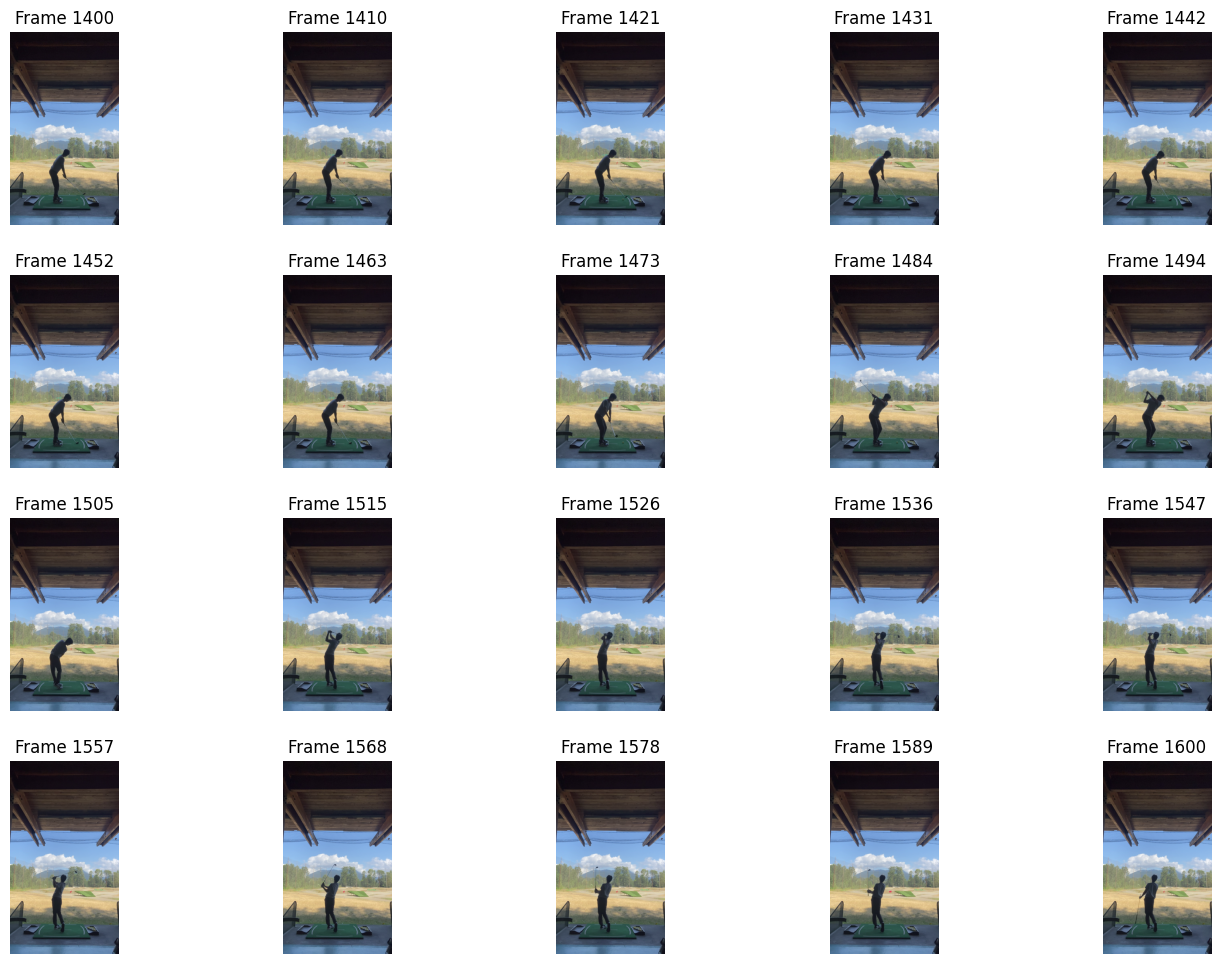

In [17]:
# Example usage
video_file = "03.MOV"  # or "03.mp4" if it's an mp4 file
start_frame = 1400
end_frame = 1600
num_frames = 20

combined_plot(video_file, start_frame, end_frame, num_frames)

Previously, I have created `scripts/roboflow_pipeline` to obtain predictions as a jsonl file. Now I need to preprocess trajectory data into fixed-length sequences and labeling them as golf swings or not